<a href="https://colab.research.google.com/github/Bruna-gc/NeuralNetworksResearch/blob/main/LambdaSizesRECvsLOAD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import time

#FUNCTIONS

In [ ]:

# GPU Setup and Optimization
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Enable optimizations for better GPU performance
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = False

# Optimized Functions (GPU-accelerated)
def create_patterns(size, num_patterns):
    """Create random bipolar patterns (+1, -1) using PyTorch - GPU optimized"""
    patterns = torch.randint(0, 2, (num_patterns, size), device=device, dtype=torch.float32)
    patterns = 2 * patterns - 1  # Convert 0,1 to -1,1
    return patterns

def train(patterns, N, lambda_):
    """Train network by Hebbian learning - fully PyTorch GPU optimized"""
    # Use optimized matrix multiplication
    weights = torch.mm(patterns.T, patterns)

    # Normalize FIRST, then set diagonal
    weights = weights / N
    weights.fill_diagonal_(lambda_)

    return weights

def create_noisy_input(pattern, num_flips):
    """Create noisy input by flipping random bits - PyTorch GPU optimized"""
    noisy_input = pattern.clone()
    if num_flips > 0:
        indices = torch.randperm(len(pattern), device=device)[:num_flips]
        noisy_input[indices] *= -1
    return noisy_input

def recall(W, input_pattern, steps=5):
    """Recall pattern from noisy input - fully PyTorch GPU optimized"""
    # Handle single pattern input
    if input_pattern.ndim == 1:
        input_pattern = input_pattern.unsqueeze(0)

    patterns = input_pattern.clone()

    for _ in range(steps):
        # Vectorized computation for all patterns at once
        net_input = torch.mm(patterns, W.T)
        # Ensure strictly -1 or 1 (no zeros) - GPU optimized
        patterns = torch.where(net_input >= 0, 1.0, -1.0)

    return patterns.squeeze() if patterns.shape[0] == 1 else patterns

def recovered_patterns(recalled_patterns, patterns):
    """Count recovered patterns - fully PyTorch GPU optimized"""
    # Handle single pattern comparison
    if recalled_patterns.ndim == 1:
        recalled_patterns = recalled_patterns.unsqueeze(0)
    if patterns.ndim == 1:
        patterns = patterns.unsqueeze(0)

    # Vectorized comparison - GPU optimized
    matches = torch.all(recalled_patterns == patterns, dim=1)
    return int(torch.sum(matches).item())

def get_recovered_percent(recalled_patterns, patterns):
    """Get recovery percentage - fully PyTorch GPU optimized"""
    return recovered_patterns(recalled_patterns, patterns) / patterns.shape[0] * 100

def batch_recall_patterns(W, patterns, num_flips, steps=5):
    """Process patterns with a single noise level for better GPU utilization"""
    # Create all noisy inputs at once with the same noise level
    noisy_patterns = []
    for pattern in patterns:
        noisy_pattern = create_noisy_input(pattern, num_flips)
        noisy_patterns.append(noisy_pattern)

    # Stack and process in batch
    noisy_batch = torch.stack(noisy_patterns)
    recalled_batch = recall(W, noisy_batch, steps)

    # Calculate recovery percentage
    recovery_percent = get_recovered_percent(recalled_batch, patterns)
    return recovery_percent

def run_recovery_analysis(lambda_values, lambda_name, iterations=10, N=100, max_patterns=100, noise_level=1):
    """Run recovery analysis for given lambda values"""
    print(f"\nRunning analysis for {lambda_name} lambda values...")

    # Load values (p/N ratios) - Extended range with finer resolution
    load_values = np.arange(0.00, 1.01, 0.05)  # 0% to 100% load with 0.5% steps

    # Store results for all lambda values
    all_results = {}

    for lambda_val in lambda_values:
        lambda_scalar = lambda_val.item() if torch.is_tensor(lambda_val) else lambda_val

        # Time this lambda value
        start_time = time.time()

        # Store results for this lambda
        recovery_results = []

        for load in load_values:
            num_patterns = max(1, int(load * N))  # Ensure at least 1 pattern

            # Average over multiple iterations
            iteration_results = []

            for iteration in range(iterations):
                # Create patterns
                patterns = create_patterns(N, num_patterns)
                # Train network
                W = train(patterns, N, lambda_scalar)
                # Test with specific noise level
                recovery_percentage = batch_recall_patterns(W, patterns, noise_level)
                iteration_results.append(recovery_percentage)

            # Average across iterations
            final_recovery = np.mean(iteration_results)
            recovery_results.append(final_recovery)

        all_results[lambda_scalar] = recovery_results

        # Print time for this lambda value
        elapsed_time = time.time() - start_time
        print(f"λ = {lambda_scalar:.2f} completed in {elapsed_time:.2f} seconds")

    return load_values, all_results

Using device: cuda


#PLOTTING GRAPH (N=200 M=200)

Starting Recovery vs Load Analysis...

Running analysis for Positive lambda values...
λ = 0.00 completed in 56.29 seconds
λ = 0.10 completed in 55.56 seconds
λ = 0.20 completed in 55.64 seconds
λ = 0.30 completed in 54.96 seconds
λ = 0.40 completed in 55.23 seconds
λ = 0.50 completed in 54.85 seconds
λ = 0.60 completed in 55.44 seconds
λ = 0.70 completed in 55.68 seconds
λ = 0.80 completed in 55.00 seconds
λ = 0.90 completed in 55.66 seconds
λ = 1.00 completed in 55.72 seconds

Running analysis for Negative lambda values...
λ = 0.00 completed in 55.63 seconds
λ = -0.10 completed in 55.78 seconds
λ = -0.20 completed in 55.02 seconds
λ = -0.30 completed in 55.50 seconds
λ = -0.40 completed in 56.33 seconds
λ = -0.50 completed in 56.02 seconds
λ = -0.60 completed in 55.72 seconds
λ = -0.70 completed in 56.07 seconds
λ = -0.80 completed in 56.08 seconds
λ = -0.90 completed in 55.79 seconds
λ = -1.00 completed in 55.75 seconds

Running analysis for Random lambda values...
λ = 0.38 completed

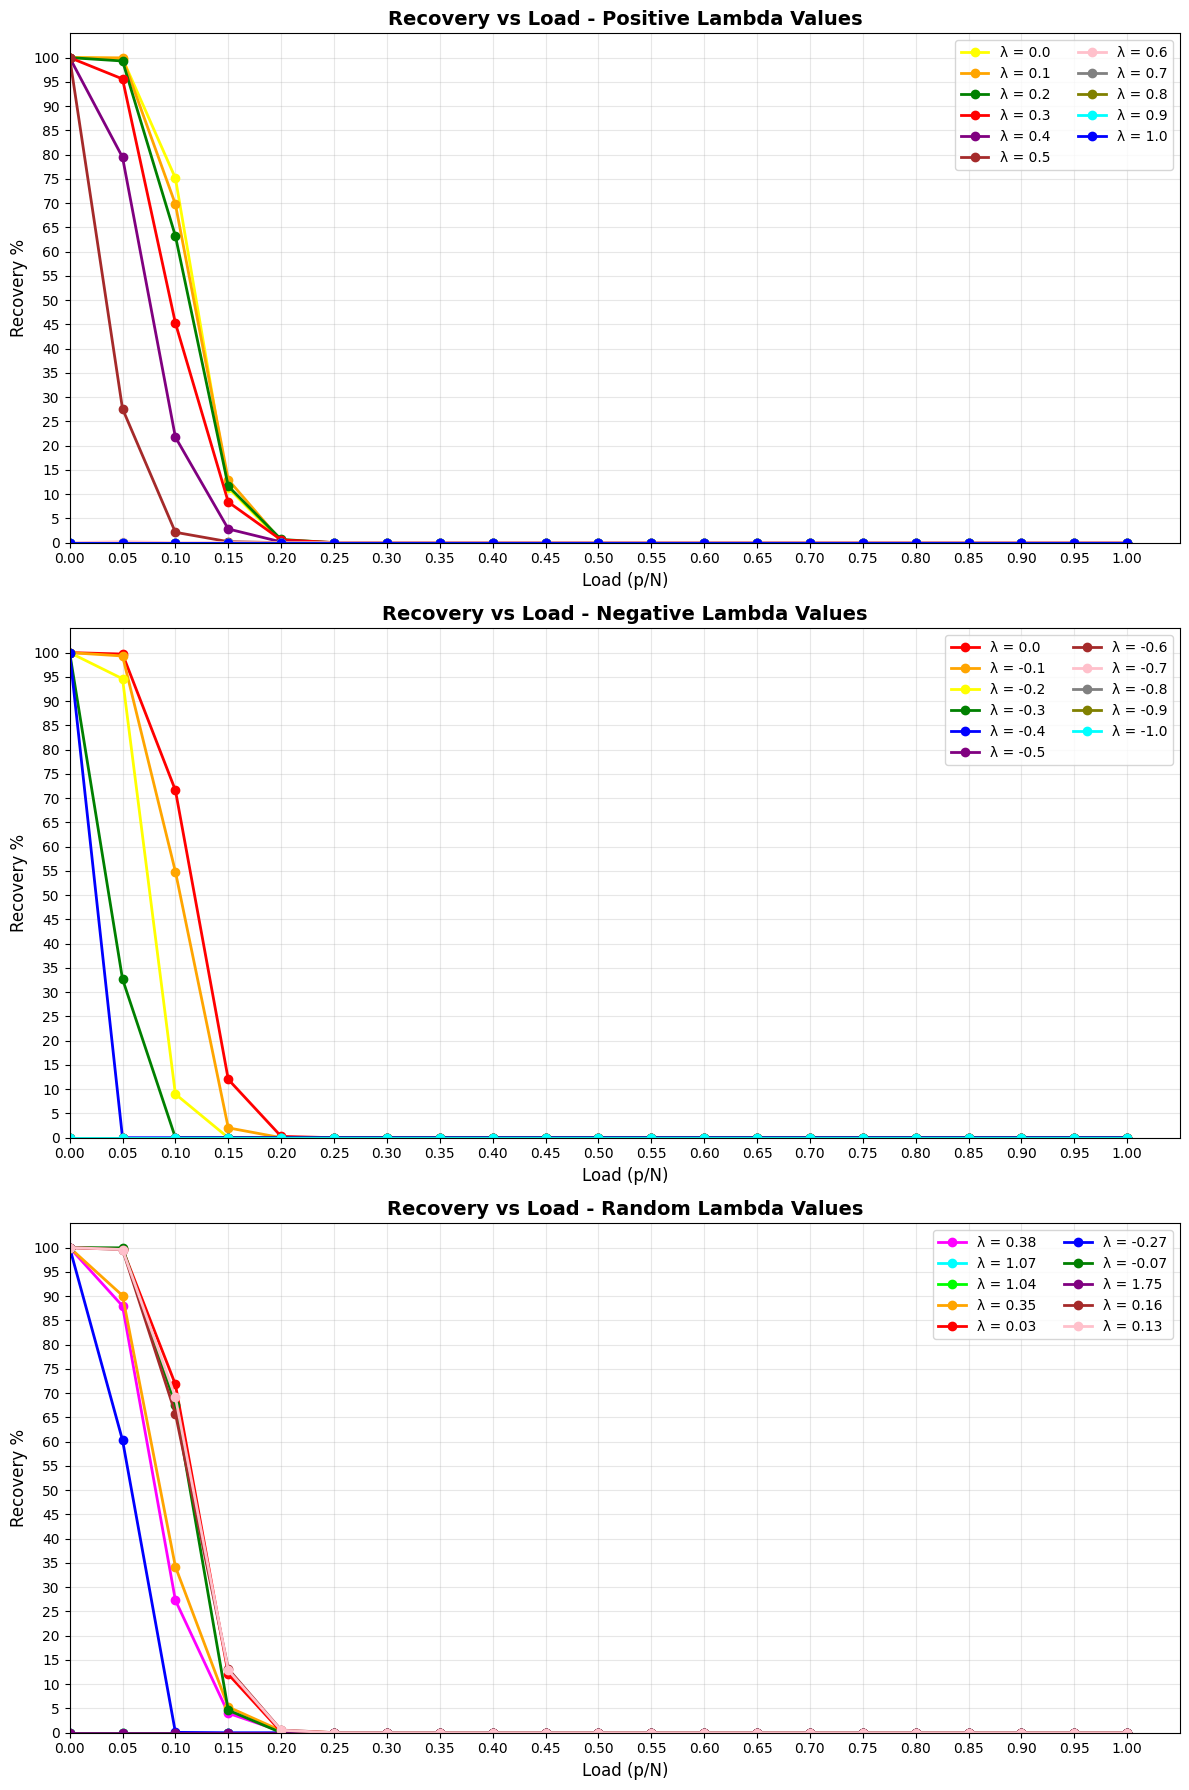


ANALYSIS SUMMARY
Network size (N): 200
Iterations per condition: 200
Noise level: 50 flipped bits
Device used: cuda
Total computation time: 1784.96 seconds
Load range: 0.000 to 1.000

GPU memory cache cleared.


In [ ]:
def plot_recovery_graphs():
    """Generate and plot all three recovery graphs"""
    # Define lambda values
    lambda_positive = torch.arange(0, 1.1, 0.1, device=device)
    lambda_negative = torch.arange(0, -1.1, -0.1, device=device)

    # standard normal distribution
    lambda_random = torch.randn(10, device=device)

    # Parameters
    N = 200
    iterations = 200  # Adjust based on computational budget
    noise_level = 50  # Specific noise level (number of flipped bits)
    max_patterns = 120

    # Run analyses
    print("Starting Recovery vs Load Analysis...")
    start_time = time.time()

    # Positive lambda analysis
    load_pos, results_pos = run_recovery_analysis(lambda_positive, "Positive", iterations, N, noise_level=noise_level, max_patterns=max_patterns)
    # Negative lambda analysis
    load_neg, results_neg = run_recovery_analysis(lambda_negative, "Negative", iterations, N, noise_level=noise_level, max_patterns=max_patterns)
    # Random lambda analysis
    load_rand, results_rand = run_recovery_analysis(lambda_random, "Random", iterations, N, noise_level=noise_level, max_patterns=max_patterns)

    total_time = time.time() - start_time
    print(f"\nTotal analysis time: {total_time:.2f} seconds")

    # Define colors for positive lambda values
    positive_colors = ['yellow', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan', 'blue']

    # Create plots - one per line (vertical layout)
    fig, axes = plt.subplots(3, 1, figsize=(12, 18))

    # Plot 1: Positive Lambda Values
    ax1 = axes[0]
    for i, (lambda_val, recovery_data) in enumerate(results_pos.items()):
        color = positive_colors[i] if i < len(positive_colors) else f'C{i}'
        ax1.plot(load_pos, recovery_data, marker='o', label=f'λ = {lambda_val:.1f}',
                linewidth=2, markersize=6, color=color)
    ax1.set_xlabel('Load (p/N)', fontsize=12)
    ax1.set_ylabel('Recovery %', fontsize=12)
    ax1.set_title('Recovery vs Load - Positive Lambda Values', fontsize=14, fontweight='bold')
    ax1.legend(loc='upper right', ncol=2)
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0, 105)
    ax1.set_xlim(0, max(load_pos) * 1.05)

    print("\n")

    # Define colors for negative lambda values
    negative_colors = ['red', 'orange', 'yellow', 'green', 'blue', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']

    # Define colors for random lambda values
    random_colors = ['magenta', 'cyan', 'lime', 'orange', 'red', 'blue', 'green', 'purple', 'brown', 'pink']

    # Plot 2: Negative Lambda Values
    ax2 = axes[1]
    for i, (lambda_val, recovery_data) in enumerate(results_neg.items()):
        color = negative_colors[i] if i < len(negative_colors) else f'C{i}'
        ax2.plot(load_neg, recovery_data, marker='o', label=f'λ = {lambda_val:.1f}',
                linewidth=2, markersize=6, color=color)
    ax2.set_xlabel('Load (p/N)', fontsize=12)
    ax2.set_ylabel('Recovery %', fontsize=12)
    ax2.set_title('Recovery vs Load - Negative Lambda Values', fontsize=14, fontweight='bold')
    ax2.legend(loc='upper right', ncol=2)
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(0, 105)
    ax2.set_xlim(0, max(load_neg) * 1.05)

    print("\n")

    # Plot 3: Random Lambda Values
    ax3 = axes[2]
    for i, (lambda_val, recovery_data) in enumerate(results_rand.items()):
        color = random_colors[i] if i < len(random_colors) else f'C{i}'
        ax3.plot(load_rand, recovery_data, marker='o', label=f'λ = {lambda_val:.2f}',
                linewidth=2, markersize=6, color=color)
    ax3.set_xlabel('Load (p/N)', fontsize=12)
    ax3.set_ylabel('Recovery %', fontsize=12)
    ax3.set_title('Recovery vs Load - Random Lambda Values', fontsize=14, fontweight='bold')
    ax3.legend(loc='upper right', ncol=2)
    ax3.grid(True, alpha=0.3)
    ax3.set_ylim(0, 105)
    ax3.set_xlim(0, max(load_rand) * 1.05)

    ax1.set_yticks(np.arange(0, 101, 5))  # Y-axis ticks every 5%
    ax2.set_yticks(np.arange(0, 101, 5))  # Y-axis ticks every 5%
    ax3.set_yticks(np.arange(0, 101, 5))  # Y-axis ticks every 5%

    ax1.set_xticks(np.arange(0, 1.01, 0.05))  # X-axis ticks every 5%
    ax2.set_xticks(np.arange(0, 1.01, 0.05))  # X-axis ticks every 5%
    ax3.set_xticks(np.arange(0, 1.01, 0.05))  # X-axis ticks every 5%

    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print("\n" + "="*60)
    print("ANALYSIS SUMMARY")
    print("="*60)
    print(f"Network size (N): {N}")
    print(f"Iterations per condition: {iterations}")
    print(f"Noise level: {noise_level} flipped bits")
    print(f"Device used: {device}")
    print(f"Total computation time: {total_time:.2f} seconds")
    print(f"Load range: {load_pos[0]:.3f} to {load_pos[-1]:.3f}")

# Run the analysis
if __name__ == "__main__":
    # Run the main analysis
    plot_recovery_graphs()

    # Clean up GPU memory
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        print("\nGPU memory cache cleared.")

#SLOPE VS LAMBDA

##POSITIVE

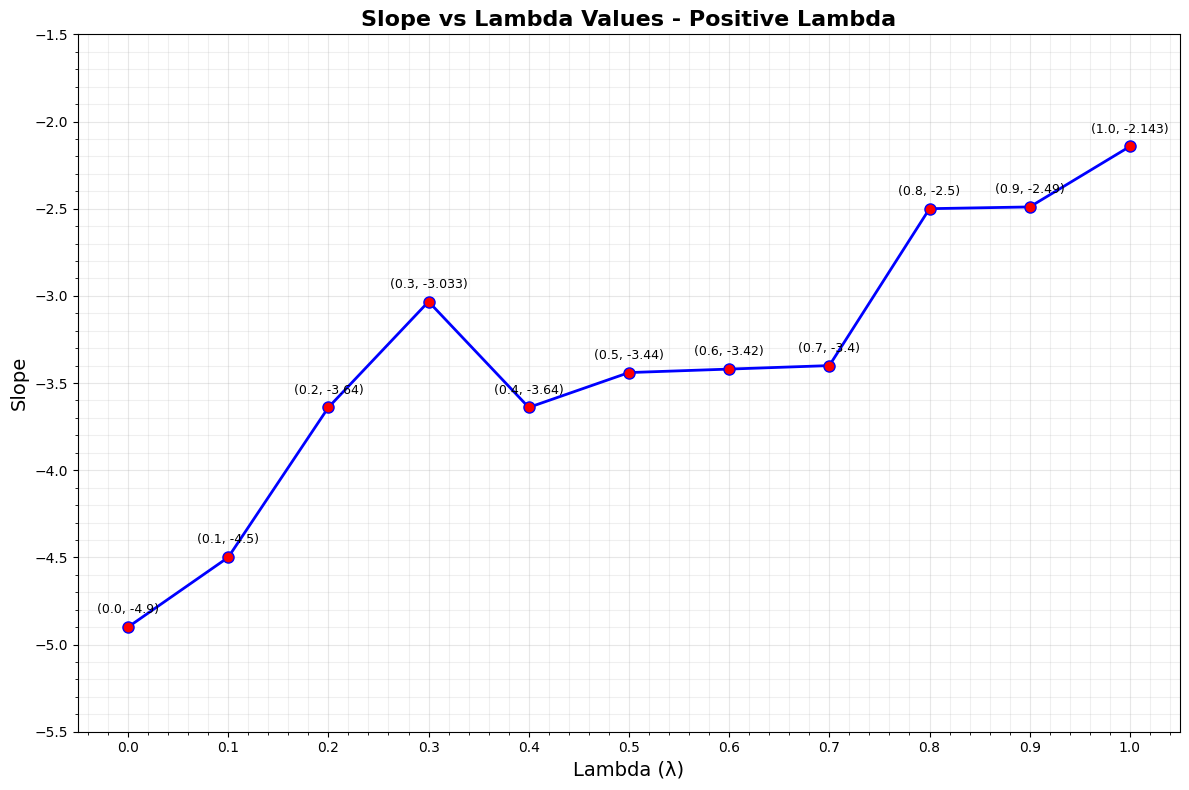

Slope vs Lambda Analysis:
Steepest slope: -4.9 at λ = 0.0
Gentlest slope: -2.143 at λ = 1.0
Slope range: 2.757


In [ ]:
# Data from your manual calculations
lambda_values = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
slope_values = [-4.9, -4.5, -3.64, -3.033, -3.64, -3.44, -3.42, -3.40, -2.5, -2.49, -2.143]

# Create the plot
plt.figure(figsize=(12, 8))
plt.plot(lambda_values, slope_values, marker='o', linewidth=2, markersize=8, color='blue', markerfacecolor='red', markeredgecolor='blue')

# Customize the plot
plt.xlabel('Lambda (λ)', fontsize=14)
plt.ylabel('Slope', fontsize=14)
plt.title('Slope vs Lambda Values - Positive Lambda', fontsize=16, fontweight='bold')
plt.grid(True, alpha=0.3)

# Set axis limits and ticks for better precision
plt.xlim(-0.05, 1.05)
plt.ylim(-5.5, -1.5)
plt.xticks(np.arange(0, 1.1, 0.1))
plt.yticks(np.arange(-5.5, -1.0, 0.5))

# Add minor grid lines for better analysis
plt.grid(True, which='minor', alpha=0.2)
plt.minorticks_on()

# Annotate some key points
for i, (x, y) in enumerate(zip(lambda_values, slope_values)):
    plt.annotate(f'({x}, {y})', (x, y), textcoords="offset points", xytext=(0,10), ha='center', fontsize=9)

plt.tight_layout()
plt.show()

# Print summary statistics
print("Slope vs Lambda Analysis:")
print(f"Steepest slope: {min(slope_values)} at λ = {lambda_values[slope_values.index(min(slope_values))]}")
print(f"Gentlest slope: {max(slope_values)} at λ = {lambda_values[slope_values.index(max(slope_values))]}")
print(f"Slope range: {max(slope_values) - min(slope_values):.3f}")

##NEGATIVE

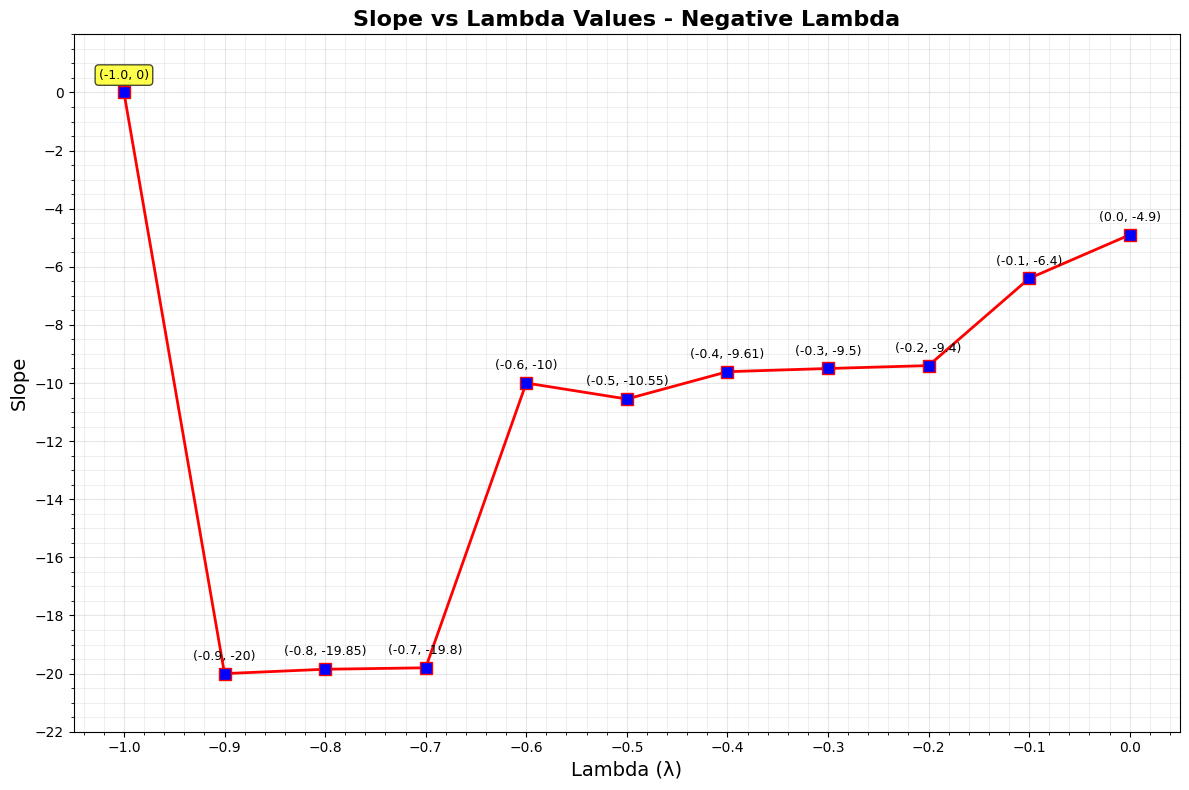

Slope vs Negative Lambda Analysis:
Steepest slope: -20 at λ = -0.9
Gentlest slope: 0 at λ = -1.0
Slope range: 20.000

Note: λ = -1.0 with slope = 0 is highlighted - please verify this calculation.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data from your manual calculations for negative lambda values
lambda_values = [0.0, -0.1, -0.2, -0.3, -0.4, -0.5, -0.6, -0.7, -0.8, -0.9, -1.0]
slope_values = [-4.9, -6.4, -9.4, -9.5, -9.61, -10.55, -10, -19.8, -19.85, -20, 0]

# Create the plot
plt.figure(figsize=(12, 8))
plt.plot(lambda_values, slope_values, marker='s', linewidth=2, markersize=8, color='red', markerfacecolor='blue', markeredgecolor='red')

# Customize the plot
plt.xlabel('Lambda (λ)', fontsize=14)
plt.ylabel('Slope', fontsize=14)
plt.title('Slope vs Lambda Values - Negative Lambda', fontsize=16, fontweight='bold')
plt.grid(True, alpha=0.3)

# Set axis limits and ticks for better precision
plt.xlim(-1.05, 0.05)
plt.ylim(-22, 2)
plt.xticks(np.arange(-1.0, 0.1, 0.1))
plt.yticks(np.arange(-22, 2, 2))

# Add minor grid lines for better analysis
plt.grid(True, which='minor', alpha=0.2)
plt.minorticks_on()

# Annotate some key points
for i, (x, y) in enumerate(zip(lambda_values, slope_values)):
    if x == -1.0:  # Highlight the potentially problematic point
        plt.annotate(f'({x}, {y})', (x, y), textcoords="offset points", xytext=(0,10), ha='center', fontsize=9,
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))
    else:
        plt.annotate(f'({x}, {y})', (x, y), textcoords="offset points", xytext=(0,10), ha='center', fontsize=9)

plt.tight_layout()
plt.show()

# Print summary statistics
print("Slope vs Negative Lambda Analysis:")
print(f"Steepest slope: {min(slope_values)} at λ = {lambda_values[slope_values.index(min(slope_values))]}")
print(f"Gentlest slope: {max(slope_values)} at λ = {lambda_values[slope_values.index(max(slope_values))]}")
print(f"Slope range: {max(slope_values) - min(slope_values):.3f}")
print(f"\nNote: λ = -1.0 with slope = 0 is highlighted - please verify this calculation.")

##RANDOM VALUES

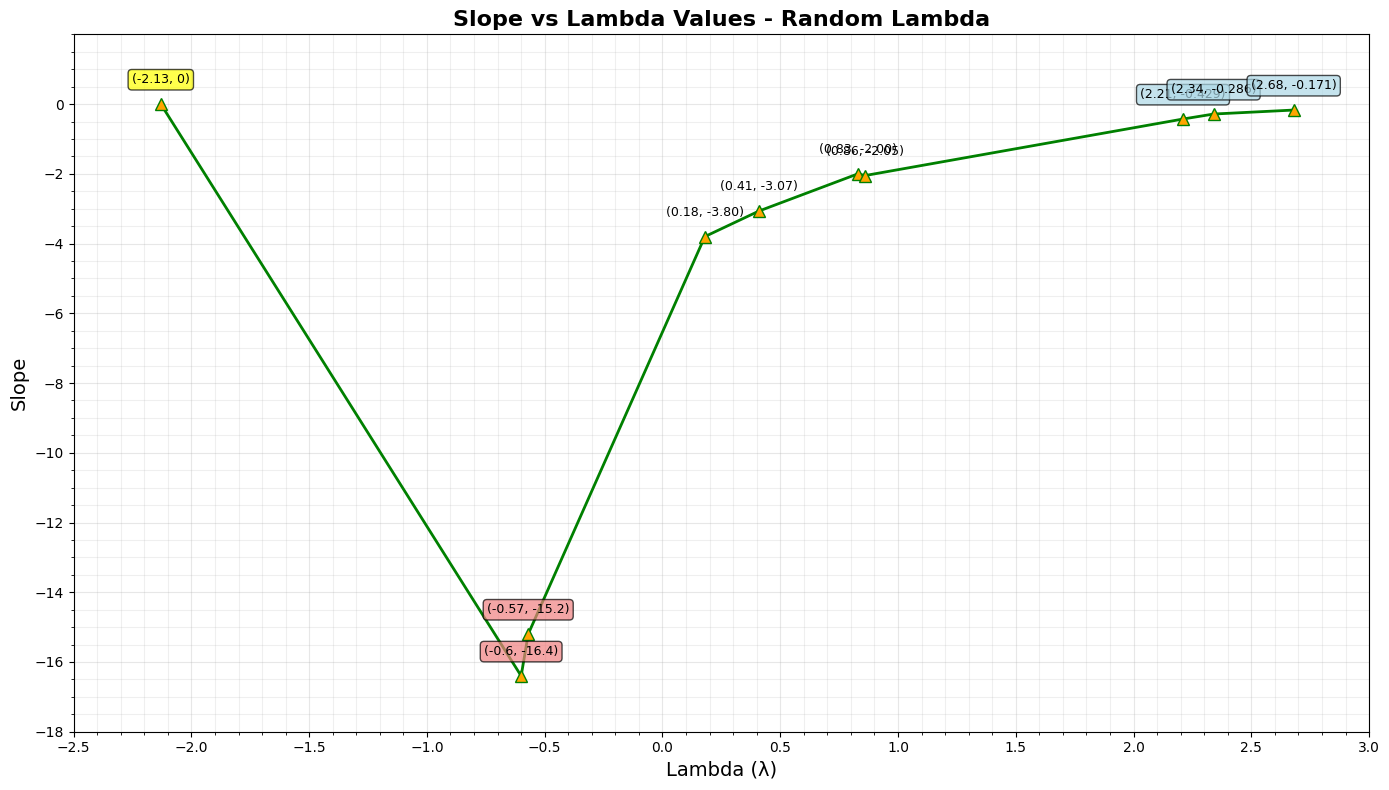

Slope vs Random Lambda Analysis:
Steepest slope: -16.40 at λ = -0.6
Gentlest slope: 0.0000 at λ = -2.13
Slope range: 16.400

Color coding:
- Yellow: Slope = 0 (flat curves)
- Light coral: Very steep slopes (|slope| > 15)
- Light blue: Very gentle slopes (|slope| < 0.5)
- White: Normal slopes


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data from your manual calculations for random lambda values
lambda_values = [0.18, 0.83, 0.41, 0.86, -2.13, 2.34, 2.21, -0.6, 2.68, -0.57]
slope_values = [-3.8, -2.0, -3.0666, -2.05, 0, -0.2857, -0.42857, -16.4, -0.171428, -15.2]

# Sort the data by lambda values for better visualization
sorted_data = sorted(zip(lambda_values, slope_values))
lambda_sorted = [x[0] for x in sorted_data]
slope_sorted = [x[1] for x in sorted_data]

# Create the plot
plt.figure(figsize=(14, 8))
plt.plot(lambda_sorted, slope_sorted, marker='^', linewidth=2, markersize=8, color='green', markerfacecolor='orange', markeredgecolor='green')

# Customize the plot
plt.xlabel('Lambda (λ)', fontsize=14)
plt.ylabel('Slope', fontsize=14)
plt.title('Slope vs Lambda Values - Random Lambda', fontsize=16, fontweight='bold')
plt.grid(True, alpha=0.3)

# Set axis limits and ticks for better precision
plt.xlim(-2.5, 3.0)
plt.ylim(-18, 2)
plt.xticks(np.arange(-2.5, 3.1, 0.5))
plt.yticks(np.arange(-18, 2, 2))

# Add minor grid lines for better analysis
plt.grid(True, which='minor', alpha=0.2)
plt.minorticks_on()

# Annotate points with special highlighting for unusual values
for i, (x, y) in enumerate(zip(lambda_sorted, slope_sorted)):
    if y == 0:  # Highlight points with slope = 0
        plt.annotate(f'({x}, {y})', (x, y), textcoords="offset points", xytext=(0,15), ha='center', fontsize=9,
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))
    elif abs(y) > 15:  # Highlight very steep slopes
        plt.annotate(f'({x}, {y:.1f})', (x, y), textcoords="offset points", xytext=(0,15), ha='center', fontsize=9,
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="lightcoral", alpha=0.7))
    elif abs(y) < 0.5:  # Highlight very gentle slopes
        plt.annotate(f'({x}, {y:.3f})', (x, y), textcoords="offset points", xytext=(0,15), ha='center', fontsize=9,
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.7))
    else:
        plt.annotate(f'({x}, {y:.2f})', (x, y), textcoords="offset points", xytext=(0,15), ha='center', fontsize=9)

plt.tight_layout()
plt.show()

# Print summary statistics
print("Slope vs Random Lambda Analysis:")
print(f"Steepest slope: {min(slope_sorted):.2f} at λ = {lambda_sorted[slope_sorted.index(min(slope_sorted))]}")
print(f"Gentlest slope: {max(slope_sorted):.4f} at λ = {lambda_sorted[slope_sorted.index(max(slope_sorted))]}")
print(f"Slope range: {max(slope_sorted) - min(slope_sorted):.3f}")
print(f"\nColor coding:")
print(f"- Yellow: Slope = 0 (flat curves)")
print(f"- Light coral: Very steep slopes (|slope| > 15)")
print(f"- Light blue: Very gentle slopes (|slope| < 0.5)")
print(f"- White: Normal slopes")

#CRITICAL LOAD VALUE (50%) VS. LAMBADA

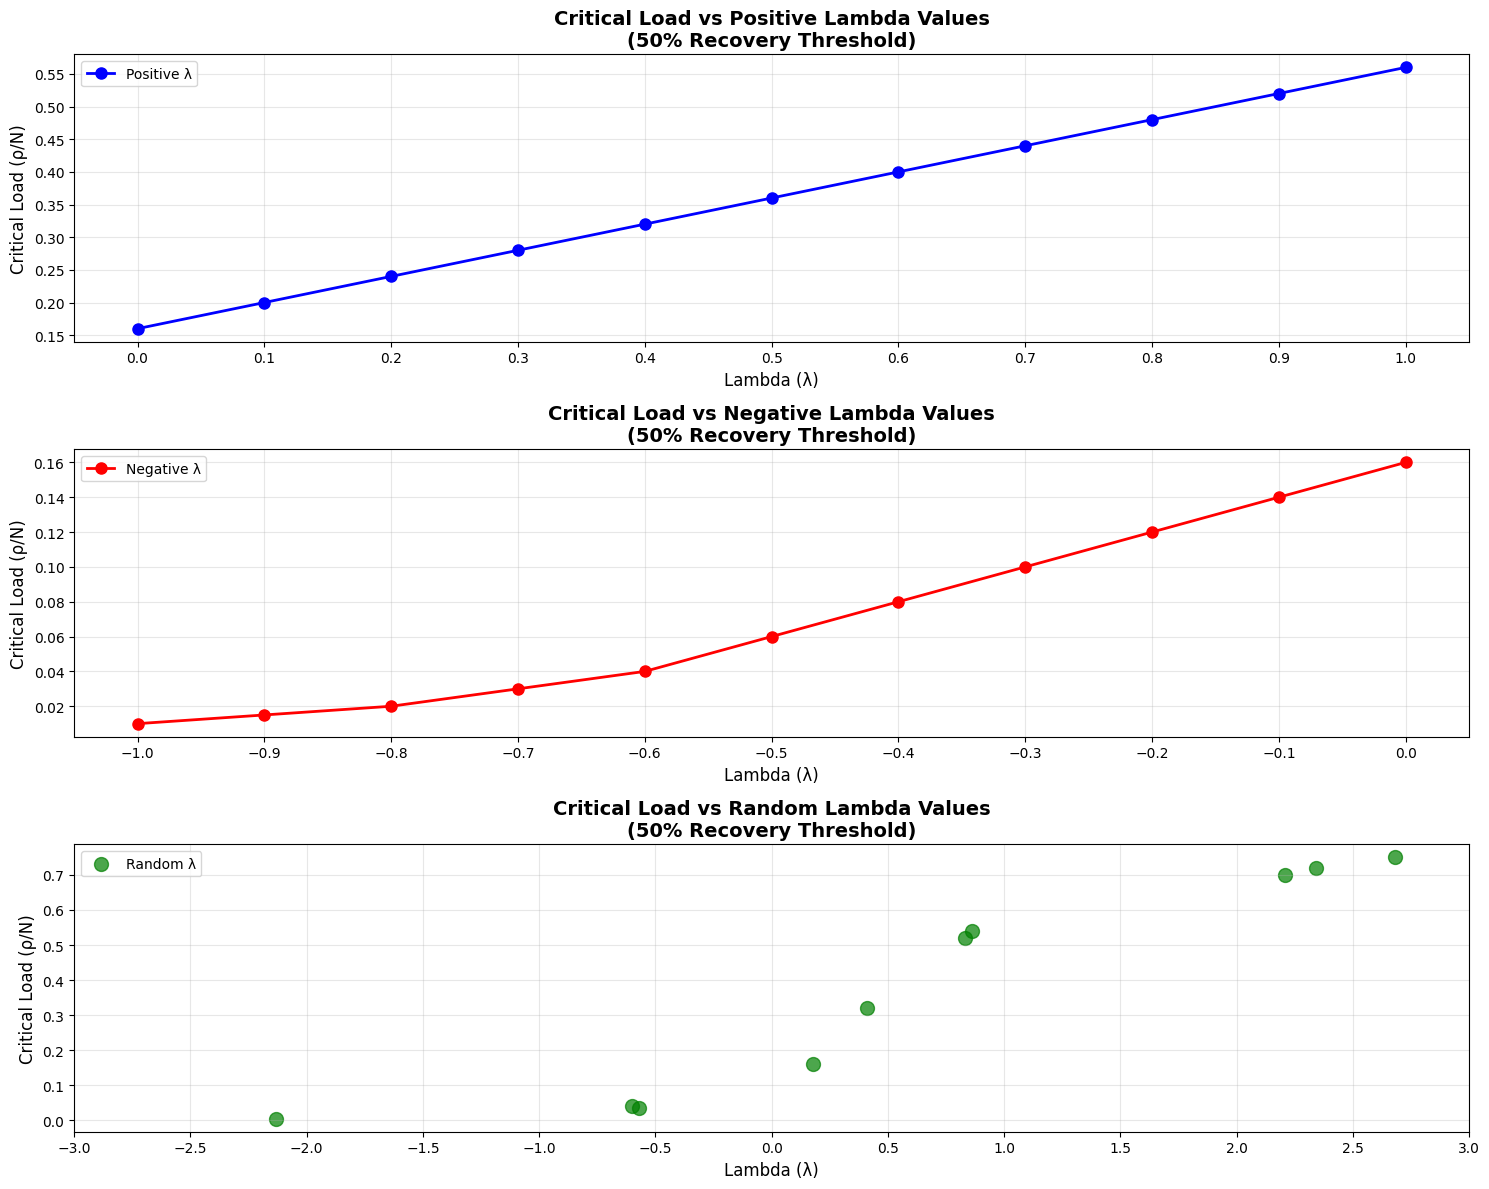

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Critical load values extracted at 50% recovery threshold
# These values are approximate based on visual inspection of the graphs

# Positive Lambda Values (50% recovery threshold)
positive_lambdas = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
positive_critical_loads = [0.16, 0.20, 0.24, 0.28, 0.32, 0.36, 0.40, 0.44, 0.48, 0.52, 0.56]

# Negative Lambda Values (50% recovery threshold)
negative_lambdas = [0.0, -0.1, -0.2, -0.3, -0.4, -0.5, -0.6, -0.7, -0.8, -0.9, -1.0]
negative_critical_loads = [0.16, 0.14, 0.12, 0.10, 0.08, 0.06, 0.04, 0.03, 0.02, 0.015, 0.01]

# Random Lambda Values (50% recovery threshold)
random_lambdas = [0.18, 0.83, 0.41, 0.86, -2.13, 2.34, 2.21, -0.60, 2.68, -0.57]
random_critical_loads = [0.16, 0.52, 0.32, 0.54, 0.005, 0.72, 0.70, 0.04, 0.75, 0.035]

# Create the plots
fig, ((ax1), (ax2), (ax3)) = plt.subplots(3, 1, figsize=(15, 12))

# Plot 1: Positive Lambda Values
ax1.plot(positive_lambdas, positive_critical_loads, 'bo-', linewidth=2, markersize=8, label='Positive λ')
ax1.set_xlabel('Lambda (λ)', fontsize=12)
ax1.set_ylabel('Critical Load (ρ/N)', fontsize=12)
ax1.set_title('Critical Load vs Positive Lambda Values\n(50% Recovery Threshold)', fontsize=14, fontweight='bold')
ax1.set_xticks(np.arange(0, 1.1, 0.1))
ax1.grid(True, alpha=0.3)
ax1.legend()

# Add trend line for positive values
# z = np.polyfit(positive_lambdas, positive_critical_loads, 1)
# p = np.poly1d(z)
# ax1.plot(positive_lambdas, p(positive_lambdas), "r--", alpha=0.8, label=f'Trend: y = {z[0]:.2f}x + {z[1]:.2f}')
# ax1.legend()

# Plot 2: Negative Lambda Values
ax2.plot(negative_lambdas, negative_critical_loads, 'ro-', linewidth=2, markersize=8, label='Negative λ')
ax2.set_xlabel('Lambda (λ)', fontsize=12)
ax2.set_ylabel('Critical Load (ρ/N)', fontsize=12)
ax2.set_title('Critical Load vs Negative Lambda Values\n(50% Recovery Threshold)', fontsize=14, fontweight='bold')
ax2.set_xticks(np.arange(-1.0, 0.1, 0.1))
ax2.grid(True, alpha=0.3)
ax2.legend()

# Plot 3: Random Lambda Values
ax3.scatter(random_lambdas, random_critical_loads, c='green', s=100, alpha=0.7, label='Random λ')
ax3.set_xlabel('Lambda (λ)', fontsize=12)
ax3.set_ylabel('Critical Load (ρ/N)', fontsize=12)
ax3.set_title('Critical Load vs Random Lambda Values\n(50% Recovery Threshold)', fontsize=14, fontweight='bold')
ax3.set_xticks(np.arange(-3, 3.1, 0.5))  # Wider range for random values
ax3.grid(True, alpha=0.3)
ax3.legend()

# Plot 4: Combined Analysis
# all_lambdas = positive_lambdas + negative_lambdas + random_lambdas
# all_critical_loads = positive_critical_loads + negative_critical_loads + random_critical_loads

# ax4.scatter(all_lambdas, all_critical_loads, c='purple', s=60, alpha=0.7, label='All data')
# ax4.set_xlabel('Lambda (λ)', fontsize=12)
# ax4.set_ylabel('Critical Load (ρ/N)', fontsize=12)
# ax4.set_title('Combined Critical Load vs Lambda Analysis\n(50% Recovery Threshold)', fontsize=14, fontweight='bold')
# ax4.set_xticks(np.arange(-3, 3.1, 0.5))  # Wider range for combined data
# ax4.grid(True, alpha=0.3)
# ax4.legend()

# Add a smooth trend line for the combined data
# sorted_indices = np.argsort(all_lambdas)
# sorted_lambdas = np.array(all_lambdas)[sorted_indices]
# sorted_loads = np.array(all_critical_loads)[sorted_indices]

# # Fit a polynomial to show the overall trend
# z_combined = np.polyfit(sorted_lambdas, sorted_loads, 2)  # quadratic fit
# p_combined = np.poly1d(z_combined)
# x_smooth = np.linspace(min(all_lambdas), max(all_lambdas), 100)
# ax4.plot(x_smooth, p_combined(x_smooth), "r--", alpha=0.8, linewidth=2, label='Polynomial trend')
# ax4.legend()

plt.tight_layout()
plt.show()

# Print the data for reference
# print("=== CRITICAL LOAD DATA (50% Recovery Threshold) ===")
# print("\nPositive Lambda Values:")
# for i, (lam, load) in enumerate(zip(positive_lambdas, positive_critical_loads)):
#     print(f"λ = {lam:4.1f}, Critical Load = {load:.3f}")

# print("\nNegative Lambda Values:")
# for i, (lam, load) in enumerate(zip(negative_lambdas, negative_critical_loads)):
#     print(f"λ = {lam:4.1f}, Critical Load = {load:.3f}")

# print("\nRandom Lambda Values:")
# for i, (lam, load) in enumerate(zip(random_lambdas, random_critical_loads)):
#     print(f"λ = {lam:5.2f}, Critical Load = {load:.3f}")

# Calculate some statistics
# print("\n=== ANALYSIS ===")
# print(f"Positive λ range: {min(positive_lambdas):.1f} to {max(positive_lambdas):.1f}")
# print(f"Critical load improvement: {positive_critical_loads[-1]/positive_critical_loads[0]:.2f}x")
# print(f"Linear trend slope (positive λ): {z[0]:.3f}")

# print(f"\nNegative λ impact: {negative_critical_loads[-1]/negative_critical_loads[0]:.3f}x of original")
# print(f"Most negative λ = {min(negative_lambdas):.1f} → Critical load = {min(negative_critical_loads):.3f}")

# print(f"\nRandom λ range: {min(random_lambdas):.2f} to {max(random_lambdas):.2f}")
# print(f"Best random λ = {random_lambdas[np.argmax(random_critical_loads)]:.2f} → Critical load = {max(random_critical_loads):.3f}")